In [1]:
import os
import numpy as np
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' #omit info 
from learnMSA.msa_hmm import Configuration, Align, Visualize, Emitter, Transitioner, Initializers, Training
from learnMSA.msa_hmm.SequenceDataset import SequenceDataset
from learnMSA.protein_language_models import Common, EmbeddingBatchGenerator

2025-02-06 10:05:44.336164: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-06 10:05:44.352262: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-06 10:05:44.357184: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1738832745.613021  155802 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1738832745.649298  155802 cuda_executor.cc:1015] succ


# Experimental demo: learnMSA + protein language model

This notebook demonstrates how to align a set of protein sequences with learnMSA supported by a large, pre-trained protein language model.

This configuration of learnMSA - although a prototype - is the most accurate variant of learnMSA currently available. It is also the most computationally expensive. It is recommended to run this notebook on a GPU.

In [3]:
# Your fasta file with unaligned sequences.

train_filename = "test/data/egf.fasta"

# Reference file with aligned sequences that have matching IDs to (potentially a subset of) the 
# sequences in the train_file.
# Replace with empty string if no reference is available.
ref_filename = "test/data/egf.ref"

# The number of independently trained models.
num_models = 4

# Use sequence weights based on a rapid pre-clustering of the sequences (requires mmseqs2 to be installed)
use_weights = True

# Align long insertions with an external aligner left unaligned by the main MSA stage (requires famsa to be installed).
align_insertions = True

HMM training supported by protein embeddings:

In [3]:
def align(filename, out_filename):
    scoring_model_config = Common.ScoringModelConfig()
    config = Configuration.make_default(num_models, 
                                        use_language_model=True, 
                                        scoring_model_config=scoring_model_config)
    # we have to define a special model- and batch generator if using a language model
    # because the emission probabilities are computed differently and the LM requires specific inputs
    model_gen = EmbeddingBatchGenerator.make_generic_embedding_model_generator(config["scoring_model_config"].dim)
    batch_gen = EmbeddingBatchGenerator.EmbeddingBatchGenerator(config["scoring_model_config"])
    with SequenceDataset(train_filename, fmt="fasta") as data:
        config["crop_long_seqs"] = int(np.ceil(2 * np.mean(data.seq_lens))) #comment out to disable cropping
        alignment_model = Align.run_learnMSA(data,
                                            out_filename,
                                            config, 
                                            model_generator=model_gen,
                                            batch_generator=batch_gen,
                                            sequence_weights=Align.compute_sequence_weights(train_filename, "tmp", config["cluster_seq_id"]),
                                            verbose=True,
                                            align_insertions=True)
    return alignment_model

Training of 4 models on file egf.fasta
Configuration: 
{
num_models : 4
transitioner : ProfileHMMTransitioner(
 transition_init=
    {
    begin_to_match : DefaultEntry() , match_to_end : DefaultExit() , 
    match_to_match : DefaultMatchTransition(1) , match_to_insert : DefaultMatchTransition(-1) , 
    insert_to_match : Norm(0, 0.1) , insert_to_insert : Norm(-0.5, 0.1) , 
    match_to_delete : DefaultMatchTransition(-1) , delete_to_match : Norm(0, 0.1) , 
    delete_to_delete : Norm(-0.5, 0.1) , left_flank_loop : Norm(0, 0.1) , 
    left_flank_exit : Norm(-1, 0.1) , right_flank_loop : Norm(0, 0.1) , 
    right_flank_exit : Norm(-1, 0.1) , unannotated_segment_loop : Norm(0, 0.1) , 
    unannotated_segment_exit : Norm(-1, 0.1) , end_to_unannotated_segment : Norm(-9, 0.1) , 
    end_to_right_flank : Norm(0, 0.1) , end_to_terminal : Norm(0, 0.1)
    },
 flank_init=Const(0.0),
 prior=ProfileHMMTransitionPrior(match_comp=1, insert_comp=1, delete_comp=1, alpha_flank=7000, alpha_single=10000

/home/felix/miniforge3/envs/learnMSAdev/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Computing all embeddings (this may take a while).
10% done.
20% done.
30% done.
40% done.
50% done.
60% done.
70% done.
80% done.
90% done.
100% done.
Fitting models of lengths [27 29 23 24] on 7774 sequences.
Batch size= 190 Learning rate= 0.05
Using sequence weights  [1.         0.33333334 0.05882353 ... 0.05555556 0.03030303 0.25      ] .
1 sequences are longer than 65 and will be cropped for training.
To disable cropping, use --crop disable. To change the cropping limit to X, use --crop X.
Using 1 GPUs.


I0000 00:00:1738832863.069158  155802 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1738832863.069417  155802 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1738832863.069582  155802 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1738832863.069783  155802 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Epoch 1/10


I0000 00:00:1738832865.432222  155802 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1738832865.432476  155802 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1738832865.432634  155802 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1738832865.432834  155802 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

46/46 - 23s - 500ms/step - loss: 108.0954 - loglik: -9.2066e+01 - prior: -1.6029e+01 - aux_loss: 0.0000e+00
Epoch 2/10
46/46 - 5s - 98ms/step - loss: 76.5919 - loglik: -7.1179e+01 - prior: -5.4127e+00 - aux_loss: 0.0000e+00
Epoch 3/10
46/46 - 4s - 97ms/step - loss: 74.0184 - loglik: -6.9820e+01 - prior: -4.1986e+00 - aux_loss: 0.0000e+00
Epoch 4/10
46/46 - 5s - 98ms/step - loss: 73.3531 - loglik: -6.9566e+01 - prior: -3.7873e+00 - aux_loss: 0.0000e+00
Epoch 5/10
46/46 - 4s - 98ms/step - loss: 73.3225 - loglik: -6.9691e+01 - prior: -3.6310e+00 - aux_loss: 0.0000e+00
Epoch 6/10
46/46 - 4s - 97ms/step - loss: 73.0409 - loglik: -6.9481e+01 - prior: -3.5598e+00 - aux_loss: 0.0000e+00
Epoch 7/10
46/46 - 5s - 100ms/step - loss: 72.9607 - loglik: -6.9447e+01 - prior: -3.5139e+00 - aux_loss: 0.0000e+00
Epoch 8/10
46/46 - 5s - 98ms/step - loss: 72.8548 - loglik: -6.9367e+01 - prior: -3.4877e+00 - aux_loss: 0.0000e+00
Epoch 9/10
46/46 - 4s - 98ms/step - loss: 72.8408 - loglik: -6.9374e+01 - prior

I0000 00:00:1738832931.731722  155802 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1738832931.731971  155802 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1738832931.732135  155802 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1738832931.732338  155802 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

expansions model 0: [(12, 2), (13, 3), (16, 1)]
discards model 0: []
expansions model 1: [(14, 3)]
discards model 1: []
expansions model 2: [(12, 9)]
discards model 2: []
expansions model 3: [(12, 4), (13, 2), (16, 2), (18, 2)]
discards model 3: []
Re-initialized the encoder parameters.
Fitting models of lengths [33, 32, 32, 34] on 7774 sequences.
Batch size= 190 Learning rate= 0.05
Using sequence weights  [1.         0.33333334 0.05882353 ... 0.05555556 0.03030303 0.25      ] .
1 sequences are longer than 65 and will be cropped for training.
To disable cropping, use --crop disable. To change the cropping limit to X, use --crop X.
Using 1 GPUs.


I0000 00:00:1738832937.545877  155802 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1738832937.546150  155802 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1738832937.546312  155802 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1738832937.546512  155802 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Epoch 1/20


I0000 00:00:1738832939.521466  155802 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1738832939.521724  155802 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1738832939.521885  155802 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1738832939.522085  155802 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

46/46 - 22s - 470ms/step - loss: 80.5902 - loglik: -6.5192e+01 - prior: -1.5398e+01 - aux_loss: 0.0000e+00
Epoch 2/20
46/46 - 5s - 98ms/step - loss: 69.5479 - loglik: -6.4046e+01 - prior: -5.5023e+00 - aux_loss: 0.0000e+00
Epoch 3/20
46/46 - 4s - 98ms/step - loss: 68.2501 - loglik: -6.4058e+01 - prior: -4.1925e+00 - aux_loss: 0.0000e+00
Epoch 4/20
46/46 - 5s - 98ms/step - loss: 68.1603 - loglik: -6.4412e+01 - prior: -3.7484e+00 - aux_loss: 0.0000e+00
Epoch 5/20
46/46 - 4s - 98ms/step - loss: 67.8413 - loglik: -6.4267e+01 - prior: -3.5745e+00 - aux_loss: 0.0000e+00
Epoch 6/20
46/46 - 4s - 96ms/step - loss: 67.8337 - loglik: -6.4352e+01 - prior: -3.4813e+00 - aux_loss: 0.0000e+00
Epoch 7/20
46/46 - 4s - 97ms/step - loss: 67.5047 - loglik: -6.4090e+01 - prior: -3.4150e+00 - aux_loss: 0.0000e+00
Epoch 8/20
46/46 - 5s - 99ms/step - loss: 67.6254 - loglik: -6.4270e+01 - prior: -3.3559e+00 - aux_loss: 0.0000e+00
Fitted model successfully.
Creating alignment model...
Successfully created align

I0000 00:00:1738832997.284980  155802 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1738832997.285241  155802 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1738832997.285407  155802 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1738832997.285606  155802 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Aligning 2 insertion slices with famsa.
time for generating output: 4.0655
Wrote file test/data/interactive.alignment.fasta
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step
>l=-56.23_t=0.01
............$CD.......P........N............P........CYN.HG..T..C...S........L......................RA..-....T....G..........YTCSCL....PR......Y....TGEH$.......................
>l=-60.05_t=0.01
............$CD.......S........Q............P........CRN.-G..T..C...Sl.......N......................TN..-....T....D..........YTCACF....PG......Y....TGRY$.......................
>l=-51.96_t=0.01
............$CD.......S........D............P........CLN.GG..T..C...T........L......................RS..L....D....S..........YSCACA....PG......Y....TGQH$.......................
>l=-66.06_t=0.01
............$CD.......H........V............T........CLN.GG..T..C...Q........L......................KT..L....E....D..........YTCACA....NG......Y....TGER$.......................
>l=-66.72_t=0.01
............$CD.......H........V...........

/home/felix/miniforge3/envs/learnMSAdev/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['sequences', 'indices', 'embeddings']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(
I0000 00:00:1738833006.883955  155802 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1738833006.884194  155802 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1738833006.884352  155802 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative 

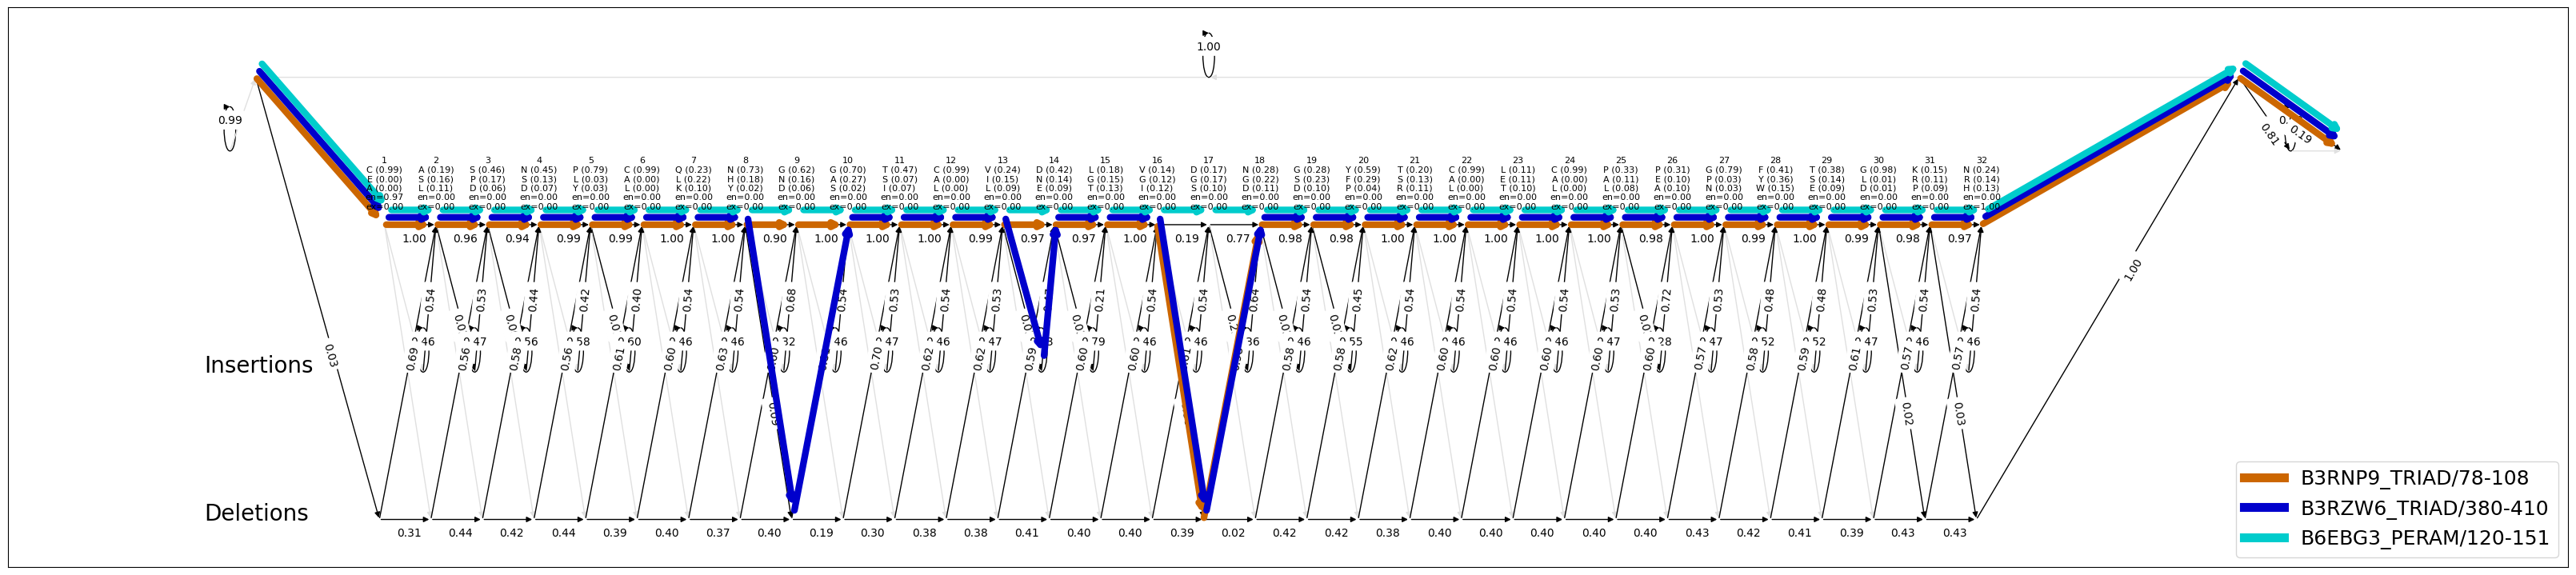

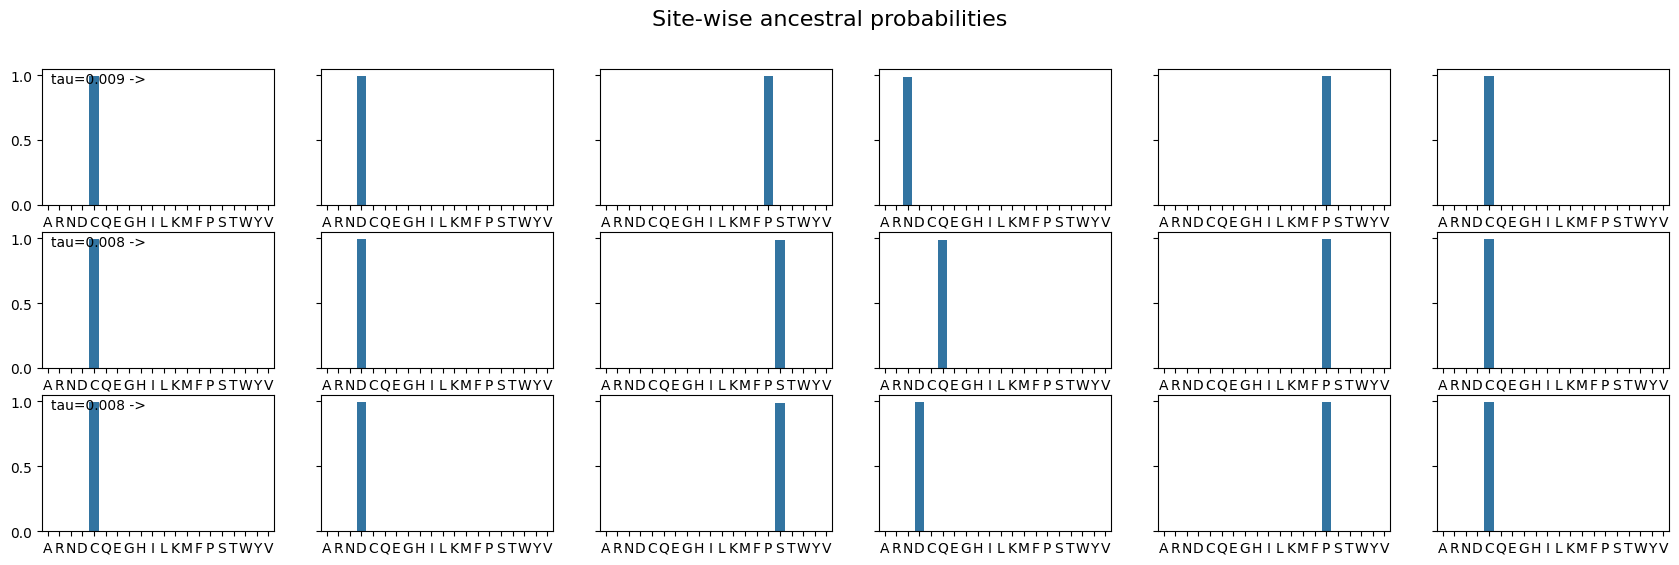

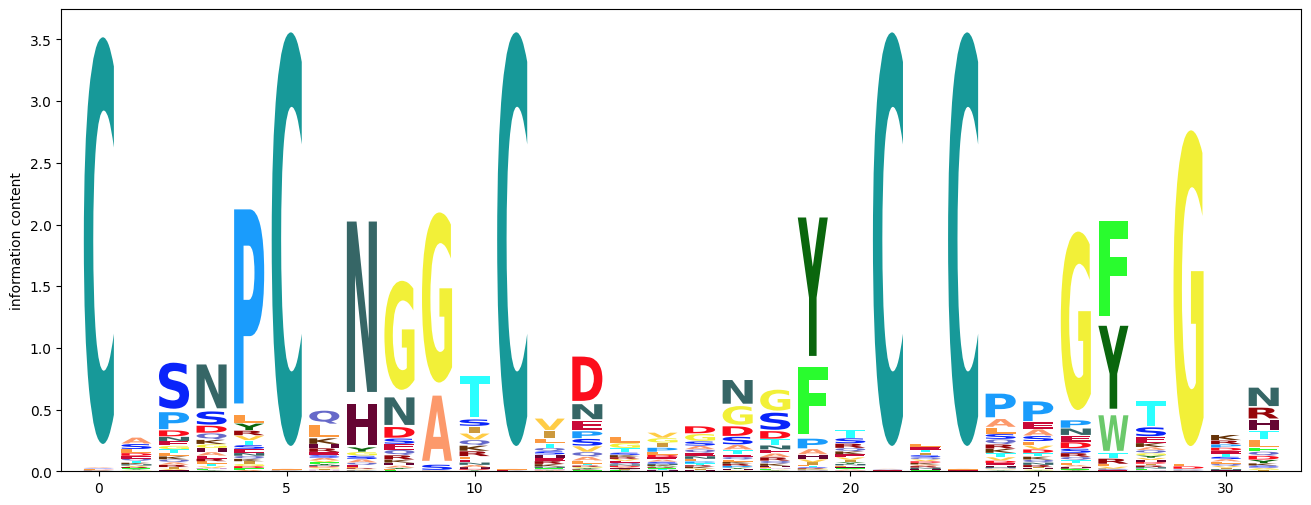

In [5]:
alignment_model = align(train_filename, "test/data/interactive.alignment.fasta") 
Visualize.print_and_plot(alignment_model, alignment_model.best_model)

In [5]:
!id_list=$(sed -n '/^>/p' {ref_filename} | sed 's/^.//') ; export MAX_N_PID_4_TCOFFEE=10000000 ; t_coffee -other_pg seq_reformat -in test/data/interactive.alignment.fasta -action +extract_seq_list ${{id_list[@]}} +rm_gap > test/data/interactive.projection.fasta

HERE: 1ixa
HERE: 1apo
HERE: 1urk
HERE: 1fsb
HERE: 1esl
HERE: 1hre
HERE: 1epi
HERE: 4tgf
HERE: 1hcgb
HERE: 1dan1
HERE: 1dan2
HERE: 1rfnb


In [6]:
!t_coffee -other_pg aln_compare -al1 {ref_filename} -al2 test/data/interactive.projection.fasta -compare_mode sp

*****************************************************
seq1       seq2          Sim   [ALL]           Tot  
egf           12         31.1    79.8 [100.0]   [ 5182]
